In [1]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.3, rc={"lines.linewidth": 2.5})
%matplotlib inline
plt.style.use('seaborn-pastel')

In [2]:
import dash
import dash_bootstrap_components as dbc
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output, State
import webbrowser
from threading import Timer

In [3]:
from mayavi import mlab 
mlab.init_notebook('ipy', 500, 500)
%gui qt

Notebook initialized with ipy backend.


In [4]:
from buoy_methods import *

In [5]:
q1 = Quaternion(0.55747131, 0.12956903, 0.5736954 , 0.58592763)
q2 = Quaternion(0.49753507, 0.50806522, 0.52711628, 0.4652709)

print(q1*q2)
# expect '(-0.3635 +0.3896i +0.3419j +0.7740k)'  we get the normalized version of this

q3 = q1*q2

(-0.3635 +0.3058i +0.8167j +0.3277k)


# Raw Data

### Acceleration [N, 3]
x, y, and z acceleration in the sensor frame

### Magnetic Field [N, 3]

x, y, z strength of the magnetic field in the sensor frame

### Angular Velocity [N, 3]

x, y, z angular velocity around the x y and z axes

### Height [N, 1]

Altitude

### Time [N, 1]

Given in seconds



             t    Ax    Ay    Az    wx    wy    wz    Bx     By     Bz   qw  \
0   852.371931 -0.67 -0.35  9.58 -0.13 -0.13 -0.06 -8.06  33.69 -42.69  1.0   
1  1176.917315 -0.67 -0.37  9.56  0.06 -0.19  0.00 -7.75  33.25 -42.69  1.0   
2  1504.410267 -0.69 -0.37  9.58 -0.13  0.25 -0.13 -7.38  33.25 -42.69  1.0   
3  1828.675270 -0.69 -0.33  9.58  0.06 -0.06 -0.13 -7.75  32.88 -43.06  1.0   
4  2156.310320 -0.68 -0.36  9.59 -0.06  0.06  0.06 -7.75  32.88 -41.88  1.0   

     qx    qy   qz  
0 -0.02  0.04  0.0  
1 -0.02  0.04  0.0  
2 -0.02  0.04  0.0  
3 -0.02  0.04  0.0  
4 -0.02  0.04  0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       1024 non-null   float64
 1   Ax      1024 non-null   float64
 2   Ay      1024 non-null   float64
 3   Az      1024 non-null   float64
 4   wx      1024 non-null   float64
 5   wy      1024 non-null   floa

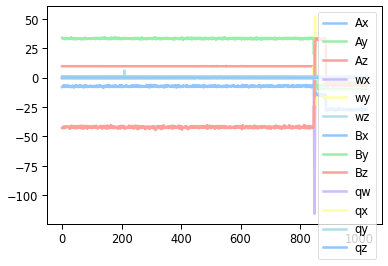

In [6]:
df  =  pd.read_csv("data/first quaternion data.csv")
print(df.head())
print(df.info())
df.drop('t',axis=1).plot()

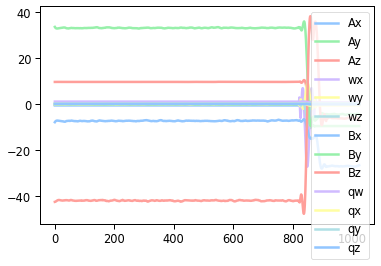

In [7]:
i=1
while i:
    try:
        df = df.apply(signal.savgol_filter, args=(53,6)) #x, window_length, polyorder,
    except:
        continue
    i=0
df.drop('t',axis=1).plot()

Further smoothing is possible with a rolling average. This makes things very smooth but at the cost of amplitude data

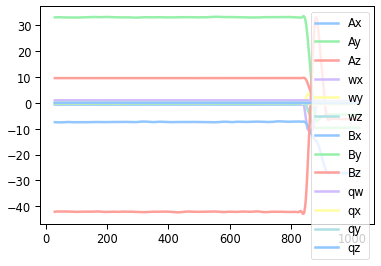

In [8]:
df = df.rolling(30).mean()
df.drop('t',axis=1).plot()

In [9]:
df.dropna(inplace=True)

# Madgwick Update

Calculates quaternions between the sensor frame and the earth frame using Acceleration, orbital velocity and magnetic field. The purpose of this filter is to find the orientation of the buoy relative to the surface of the water/earth over time. 

IMU - Inertial Measurement Unit
This project uses an Adafruit BNO055 IMU 

MARG - Magnetic, Angular Rate,and Gravity

${}^A_B{\bf q}$ Describes the orientation of frame B relative to frame A.
Where ${\bf q} = [ q_1, q_2, q_3, q_4] = [w, x, y, z]$


This filter finds ${}^S_E{\bf \hat{q}}_{est, t}$ earth frame relative to the sensor.

To rotate a vector from one frame insert a zero in the first element so you have a 4 element row vector. Then perform the following quaternion product
$$
{}^B\mathcal{v} = {}^A_B{\bf q} \otimes {}^A\mathcal{v}  \otimes {}^A_B{\bf q}^*
$$

${}^A\mathcal{v}$ and ${}^B\mathcal{v}$ are the same vector described in frame A and frame B with a zero inserted in the first element. 

In [10]:
q1 = Quaternion(0.55747131, 0.12956903, 0.5736954 , 0.58592763)
q2 = Quaternion(0.49753507, 0.50806522, 0.52711628, 0.4652709)
print(q1*q2)
# expect '(-0.3635 +0.3896i +0.3419j +0.7740k)'  we get the normalized version of this

(-0.3635 +0.3058i +0.8167j +0.3277k)


In [11]:
q = Quaternion(1, 0, 0, 1)
r = [2, 0, 0]
l = q.rotate_vector(r) #do it
#l = q.conjugate().rotate_vector(l) # undoit
#l = l*1.1

x = [0,0,0,0,0]
y = [0,0,0,0,0]
z = [0,0,0,0,0]
u = [.5,0,0,r[0],l[0]]
v = [0,.6,0,r[1],l[1]]
w = [0,0,.5,r[2],l[2]]

    
fig = mlab.figure(bgcolor=(1, 1, 1),fgcolor=(0.1, 0.1, 0.1))
mlab.axes(color=(0,0,0),figure=fig)
obj = mlab.quiver3d(x, y, z, u, v, w, line_width=3, scale_factor=1, figure=fig)
mlab.outline(color=(0,0,0))
mlab.xlabel("x",object=obj)
mlab.ylabel("y",object=obj)
mlab.zlabel("z",object=obj)
mlab.title('Quaternion Rotations',figure=fig)


No data: cannot use a Filter/Module/ModuleManager.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

In [12]:
l

array([0., 2., 0.])

In [13]:
q = Quaternion(1, 0, 0, 1)
r = [1, 0, 0]
f = q*Quaternion([0,1,0,0])*q.conjugate()
f.q

array([0., 0., 1., 0.])

## frequency [float]

$f=\frac{1}{dt}$

## dt [float]

time in between samples

$dt = \frac{1.0}{f}$


## q0 [Quaternion]
initial quaternion object.

$q = [w,x,y,z]$

Can be unit quaternion that doesn't actually rotate anything.

i = np.array([1, 0, 0, 0])

quat = Quaternion(i)


## Q[N-1]

List of quaternions from sensor frame to earth frame for each time.


## earthAcc [N-1, 3]

acceleration vectors that have been rotated by quaternions into the earth frame. 

In [14]:
acc = df.iloc[:,1:4].to_numpy()
gyr = df.iloc[:,4:7].to_numpy()
mag = df.iloc[:,7:10].to_numpy()

computed earth frame acceleration vector


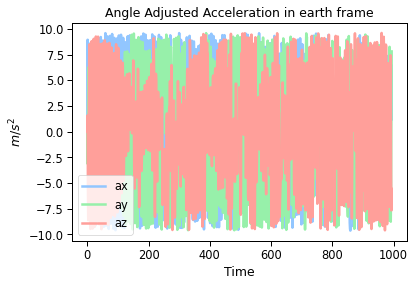

In [15]:
sample_period = 0.3 # s
freq= 1/sample_period

m = Madgwick(acc=acc, gyr=gyr,mag=mag,frequency=freq)

fig, ax = plt.subplots()
ax.plot(m.earthAcc[:,0], label='ax')
ax.plot(m.earthAcc[:,1], label='ay')
ax.plot(m.earthAcc[:,2], label='az')
ax.set_title("Angle Adjusted Acceleration in earth frame")
ax.set_xlabel("Time")
ax.set_ylabel(r"$m/s^2$")
ax.legend()

# Fixes

We should be seeing much more stable data here given our sample. The problem is clearly in the madgwick filter

Look for example data.

In [16]:
#m.earthAcc[:,2] += -10 # goodbye gravity

In [17]:
df.qw.iloc[2]

1.0000000015732007

In [18]:
quate = []
for i in range(len(df.qx)):
    quate.append(Quaternion([df.qw.iloc[i],df.qx.iloc[i],df.qy.iloc[i],df.qz.iloc[i]]))

In [19]:
a=[]
for i, q in enumerate(quate):
    a.append(q.rotate_vector(acc[i]))

In [20]:
al = pd.DataFrame(a,columns=['ax','ay','az'])

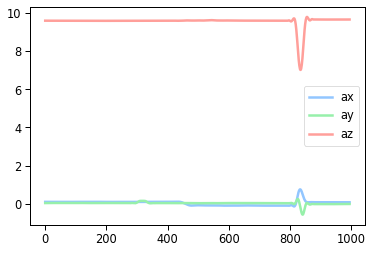

In [21]:
al.plot()

calibrate for value of gravity

In [22]:
al.az += -9.8

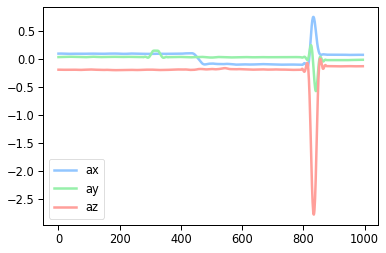

In [23]:
al.plot()

# Position Integration

Use scipy.integrate.cumptrapz which is a python iplementation of the trapezoidal method. 


scipy.integrate.cumtrapz(y, x=None, dx=1.0, axis=- 1, initial=None)[source]
Cumulatively integrate y(x) using the composite trapezoidal rule.

Parameters:

y: array_like

Values to integrate.

x: array_like, optional

The coordinate to integrate along. If None (default), use spacing dx between consecutive elements in y.

dx: float, optional

Spacing between elements of y. Only used if x is None.

axis: int, optional

Specifies the axis to cumulate. Default is -1 (last axis).

initial: scalar, optional

If given, insert this value at the beginning of the returned result. Typically this value should be 0. Default is None, which means no value at x[0] is returned and res has one element less than y along the axis of integration.

Returns:

res: ndarray

The result of cumulative integration of y along axis. If initial is None, the shape is such that the axis of integration has one less value than y. If initial is given, the shape is equal to that of y.

$$
v(t) = \int_t^{t+1} a(t) dt \approx \frac{a(t_i) + a(t_{i+1})}{2}\Delta t_{i+1}
$$


## acceleration [3,N]


## velocity [3, N-1]




## position [3,N-2]

got position


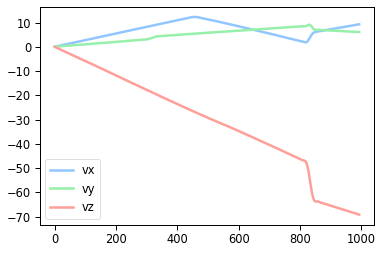

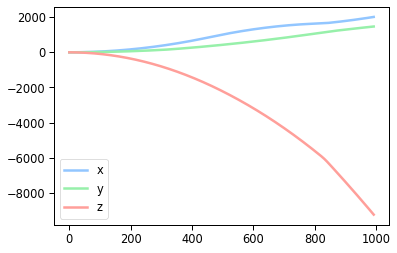

In [24]:
position = get_position(al.values,m.dt)
position.columns= ['x','y','z']
position.plot()

# Fourier Transforms

## Discrete Fourier Transforms
Given a set of sampled data you can apply the transform on the vector by multiplying it by matrices. 
This will give you a set of coefficients for each frequency in the data up to the nth frequency possible for n data points.

the nth frequency coefficient 
$$
\hat{f_k} = \sum_{j=0}^{n-1} f_je^{-i2\pi jk/n}
$$

Where:

* n is the number of samples
* j = current sample
* $f_j$ = value of the signal at time n
* k = current frequency (0 Hz to N-1 Hz)
* $\hat{f_k}$ = result of DFT amplitude and phase


To reconstruct the data from the coefficients
$$
f_k = \bigg(\sum_{j=0}^{n-1} \hat{f_j}e^{i2\pi jk/n}\bigg)\frac{1}{n}
$$

The DFT takes the sample as a vector and returns the coefficients as a vector. The data has to start with a zero index.
$$
\{f_0, f_1,f_2 ...f_n\} \implies \{\hat{f_0},\hat{f_1},\hat{f_2}...\hat{f_n}\}
$$

There is a fundamental frequency:
$$
\omega_n = e^{-i2\pi /n}
$$

This frequency can be used to form a DFT matrix. 
Given in complex numbers so that the magnitude and phase are communicated through the coeffs

## Fast Fourier Transforms

A technique for computing the DFT. An Algorithm. Clever and faster. 

Like the Discrete Fourier Transform $(N^2)$

But over small chunks and $(N\log_2 N)$

Standard use.


# Scipy

Has Function scipy.fftpack.fft

## A_xf , A_yf, A_zf

Complex coefficient per frequency 

$A_f = \alpha + i\beta$


A_xf = fftpack.fft(x)




## D
Normalized Directional Distribution per frequency

$$
D (\theta, f) = \frac{1}{\pi}\bigg\{\frac{1}{2} + a_1 \cos\theta + b_1\sin\theta + a_2\cos 2\theta+ b_2 \sin 2\theta + ...\bigg\}
$$

Columns are frequencies

Rows are angles

In [25]:
D, A, C, Q = frequency_analysis(position,dt=m.dt)

fast fourier transformed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   xx      993 non-null    float64
 1   xy      993 non-null    float64
 2   xz      993 non-null    float64
 3   yx      993 non-null    float64
 4   yy      993 non-null    float64
 5   yz      993 non-null    float64
 6   zx      993 non-null    float64
 7   zy      993 non-null    float64
 8   zz      993 non-null    float64
dtypes: float64(9)
memory usage: 69.9 KB
None


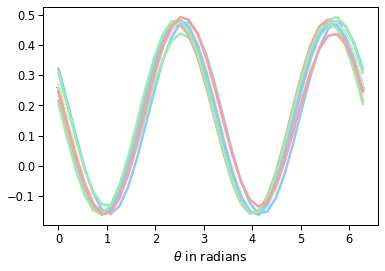

In [26]:
D.plot(legend=False)

In [27]:
D.head()

,0,1,2,3,4,5,6,7,8,9,...,983,984,985,986,987,988,989,990,991,992
$\theta$ in radians,,,,,,,,,,,,,,,,,,,,,
0.000000,0.321067,0.306943,0.215209,0.253323,0.257942,0.268477,0.262245,0.253371,0.252611,0.254695,...,0.256996,0.252657,0.250406,0.249425,0.259318,0.264432,0.256771,0.246420,0.205562,0.245911
0.179520,0.214447,0.198869,0.100652,0.139493,0.144887,0.156112,0.149651,0.140345,0.139512,0.141587,...,0.144634,0.140137,0.137657,0.136634,0.146977,0.152518,0.144821,0.134554,0.092822,0.140261
0.359039,0.100776,0.088525,-0.006070,0.028407,0.033655,0.044307,0.038397,0.029895,0.029007,0.030788,...,0.034081,0.029973,0.027561,0.026537,0.036061,0.041279,0.034697,0.025591,-0.011833,0.034226
0.538559,-0.005451,-0.010221,-0.091446,-0.065871,-0.061622,-0.052707,-0.057346,-0.063910,-0.064832,-0.063602,...,-0.060537,-0.063755,-0.065821,-0.066806,-0.059268,-0.055071,-0.059506,-0.066473,-0.094956,-0.058467
0.718078,-0.090685,-0.085066,-0.144696,-0.131422,-0.128844,-0.122589,-0.125387,-0.129129,-0.130058,-0.129576,...,-0.127127,-0.129063,-0.130560,-0.131471,-0.126834,-0.124215,-0.125722,-0.129792,-0.145840,-0.125708


In [28]:
D.max().nlargest()

1      0.492067
992    0.491459
2      0.484024
990    0.482814
991    0.480390
dtype: float64

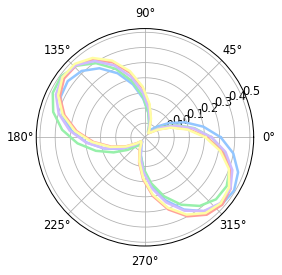

In [29]:
plt.polar(D[D.max().nlargest().keys()].iloc[:,0])  #default nlargest picks 5
plt.polar(D[D.max().nlargest().keys()].iloc[:,1])
plt.polar(D[D.max().nlargest().keys()].iloc[:,2])
plt.polar(D[D.max().nlargest().keys()].iloc[:,3])
plt.polar(D[D.max().nlargest().keys()].iloc[:,4])

In [30]:
D0 = np.arctan2(-Q.xz,Q.yz)
D0.index.name = r'frequency'

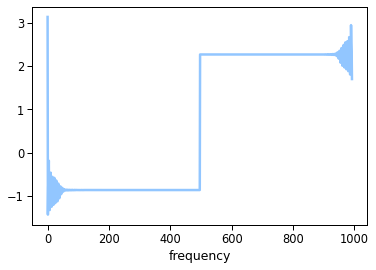

In [31]:
D0.plot()

# Frequency Domain

this needs fftshift

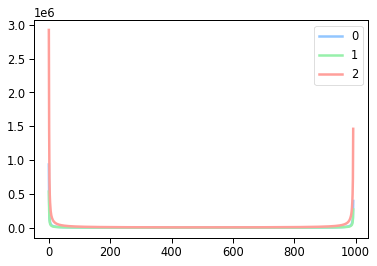

In [32]:
A.abs().plot()

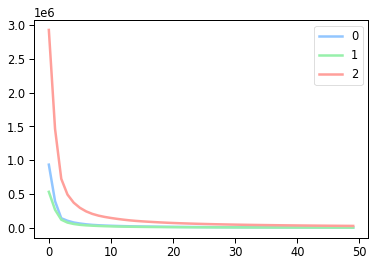

In [33]:
A[0:50].abs().plot()

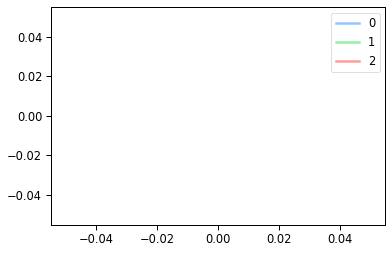

In [34]:
A[1000:1024].abs().plot()

In [35]:
A

,0,1,2
0,934393.595797-0.000000j,533241.584201-0.000000j,-2.923939e+06-0.000000e+00j
1,-16428.052231+394924.627953j,68206.471350+259723.760195j,-4.696740e+05-1.384050e+06j
2,16793.950364+142293.430034j,13009.527982+121111.751040j,-1.407166e+05-7.112819e+05j
3,8573.671891+105700.889047j,2287.116445+79072.530846j,-6.490453e+04-4.887777e+05j
4,6107.388197+80325.243894j,1335.441703+58545.752167j,-3.150777e+04-3.719221e+05j
...,...,...,...
988,1218.305073-65318.392386j,1183.222874-45984.684562j,-1.423594e+04+2.969283e+05j
989,6107.388197-80325.243894j,1335.441703-58545.752167j,-3.150777e+04+3.719221e+05j
990,8573.671891-105700.889047j,2287.116445-79072.530846j,-6.490453e+04+4.887777e+05j
991,16793.950364-142293.430034j,13009.527982-121111.751040j,-1.407166e+05+7.112819e+05j


Directional Data

# App